## import

In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import cv2
%matplotlib inline

## Data Manager Class

In [2]:
class DataManager():
    
    def __init__(self):
        self.N = 256
        self.dif = 128
        self.window = np.hamming(self.N)
        self.im_width = 128
        
    def voice2images(self, data, folder_name = "images"):
        i = 0
        _wav = self.N + self.dif * (self.im_width - 1)
        _dif = int(_wav/2)
        while(True):
            _data = data[i*_dif:i*_dif + _wav]
            if (len(_data) < _wav):
                break
            self.save_image(self.spec2image(_data), folder_name + "/" + str(i) + ".png")
            i = i + 1
    
    def images2voice(self, image_num = 10000, folder_name = "images"):
        _wav = self.N + self.dif * (self.im_width - 1)
        _dif = int(_wav/2)
        voice = np.zeros(_dif * (image_num+1))
        for i in range(image_num):
            data = self.read_image(folder_name + "/" + str(i) + ".png")
            if data is None:
                break
            voice[i*_dif:i*_dif+_wav] = voice[i*_dif:i*_dif+_wav] + self.image2spec(data)*np.r_[np.linspace(0,1,_dif), np.linspace(1,0,_dif)]
        
        """
        voice = []
        for i in range(image_num):
            data = self.read_image(folder_name + "/" + str(i) + ".png")
            voice.append(self.image2spec(data))
        """
        return voice
        
    def spec2image(self, data):
        image = []
        for i in range(self.im_width):
            image.append(self.dct(data[self.dif*i:self.dif*i + self.N]))
        return image
    
    def image2spec(self, data):
        voice = np.zeros(self.N + self.dif*(self.im_width-1))        
        vsum = np.zeros(self.N + self.dif*(self.im_width-1))
        for i in range(self.im_width):
            voice[self.dif*i:self.dif*i + self.N] = voice[self.dif*i:self.dif*i + self.N] + self.idct(data[i]) * self.window
            vsum[self.dif*i:self.dif*i + self.N] +=self.window ** 2 
        pos = (vsum != 0)
        voice[pos] /= vsum[pos]
        return voice
        
    def dct(self, data):       
        data = data * self.window
        data = scipy.fftpack.dct(data)
        pm = np.sign(data)
        #data = np.log(np.abs(data)+0.0001)
        #data = pm * data
        data = data[:int(self.N/2)]
        data = data / 20
        return data
    
    def idct(self, data):
        data = data * 20
        pm = np.sign(data)
        #data = np.exp(np.abs(data))
        #data = pm * data
        data = np.append(data, np.zeros(int(self.N/2)))
        data = scipy.fftpack.idct(data) / (2 * len(data))
        return data

    def read_wave(self, filename):
        wf = wave.open(filename , "r" )
        buf = wf.readframes(wf.getnframes())
        data = np.frombuffer(buf, dtype="int16") # 16 kHz?
        return data    
    
    def save_wave(self, data, filename):
        wf = wave.open(filename, "w")
        wf.setnchannels(2)
        wf.setsampwidth(2) #2 byte = 16 bit
        wf.setframerate(16000)
        wf.writeframes(np.array(data,  dtype="int16"))
        wf.close()
        
    def save_image(self, data, file_name):
        data = np.array(data) * 255
        cv2.imwrite(file_name, data)
        
    def read_image(self, file_name):
        data = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
        return data / 255

## Data init

In [3]:
dm = DataManager()

In [4]:
voice1 = dm.read_wave("VoiceData/kamiya.wav")
dm.voice2images(voice1, "ImageData/Kamiya_images")

voice2 = dm.read_wave("VoiceData/kizuna.wav")
dm.voice2images(voice2, "ImageData/Kizuna_images")

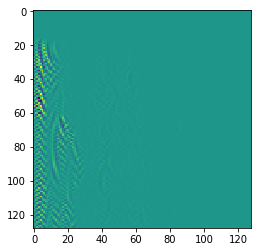

In [7]:
image = dm.spec2image(voice1)
plt.imshow(image)

In [8]:
re_voice = dm.image2spec(image)
voice = dm.images2voice(2000, "ImageData/Kamiya_images")
dm.save_wave(voice, "test.wav")